In the <a href="more-online-learning.html">last post</a> I went over AdaGrad and described a method that we can use to "automate" choosing a learning rate. The analysis techniques presented were all fairly elementary, essentially just plugging things into Zinkevich's online gradient descent regret bound.

However, many modern papers will present results in much more complicated language. It's often possible to rephrase these results in simpler terms, but it's still a good idea to understand the more advanced techniques. For one thing, if you don't understand the abstractions then you can't understand proofs that use them regardless of whether or not the abstractions are necessary. Secondly, it's not always possible to easily sidestep the abstractions. Finally, the math involved is just interesting in its own right.

So in this post I'm going to give an overview of the relevant concepts. In the interest of not making this overly long, we probably won't actually prove any regret bounds with these ideas yet - I'll save that for a seperate post. Essentially, this is a primer on some concepts in convex analysis.

Most of this post will be setting up a definition of some kind and working through its immediate consequences. The first of these is the concept of a dual norm:

<div class="definition">
<h4>Dual Norm</h4>
Given a vector space $V$ and a norm $\|\cdot\|:V\to \R$, its dual norm $\|\cdot\|_*:V\to \R$ is defined by
$$
\|x\|_* = \sup_{\|z\|=1} \langle z,x\rangle.
$$
</div>

For a finite-dimensional vector space (which is the only kind we'll be worrying about here), we can replace the $\sup$ with a $\max$.

Note that here were are using norm in the <a href=https://en.wikipedia.org/wiki/Norm_%28mathematics%29>general sense</a>; it's not necessarily the euclidean norm $\|x\|=\sqrt{\langle x,x\rangle}$.

It's a good idea to go through and verify that this is in fact a norm; the properties follow fairly readily:
$$
\|x\|_*\ge \left\langle \frac{x}{\|x\|},x\right\rangle\ge 0
$$
with equality only if $x=0$.
$$
\|x+y\|_*=\sup_{\|z\|=1} \langle z,x\rangle+\langle z,y\rangle\le \sup_{\|z\|=1} \langle z,x\rangle+\sup_{\|z\|=1}\langle z,y\rangle = \|x\|_*+\|y\|_*
$$
and for some scalar $c$:
$$
\|cx\|_*=\sup_{\|z\|=1} \langle z,cx\rangle = \sup_{\|z\|=1} c\langle z,x\rangle=c\|x\|_*
$$

In general, a thing is a "dual" to something else when the "dual of the dual" is the original thing, so we'll sketch a proof of this. Note that this is actually <i>not easy</i> to do! We'll need a somewhat complicated result called the <a href=https://en.wikipedia.org/wiki/Hahn%E2%80%93Banach_theorem>Hahn-Banach Theorem</a>.

<div style="margin-left: 3em; margin-right: 6em;" class="aside">
<p>
First let's notice that since $\|\cdot\|_{**}$ is a norm, we need only show that $\|z\|_{**}=\|z\|$ for $\|z\|=1$. So:
$$
\|z\|_{**} =\sup_{\|x\|_*=1}\langle x,z\rangle 
$$
Now notice that $\|x\|_*=1$ implies that $\sup_{\|z\|=1} \langle x,z\rangle =1$, so that
$$
\|z\|_{**} =\sup_{\|x\|_*=1}\langle x,z\rangle \le 1
$$
So that's halfway there - now we need to show that $\|z\|_{**}\ge 1$. Unfortunately, this part gets more hairy. Let $\phi(x)$ be a linear functional defined on the subspace $(z)$ spanned by $z$ such that
$$
\phi(z)=\|z\|=1
$$
Then $\phi(x)$ is dominated by $p(x)=\|x\|$ on the subspace $(z)$ spanned by $z$. By the Hahn-Banach theorem, we can extend $\phi(x)$ on $(z)$ to a linear functional $\psi(v)$ on all all of $V$ such that $\psi(z)=\phi(z)$ and $\psi(x)\le p(x)$ for all $x\in V$. Now since we're dealing with finite dimensional vector spaces, we can identify linear functionals with inner products. That is, there exists some vector $y$ such that $\psi(x)=\langle x,y\rangle$. The conditions on $\psi$ imply that $\|y\|_*=1$. Further, $\langle y,z\rangle = 1$ so that
$$
\|z\|_{**}\ge \langle y,z\rangle = 1
$$
which shows that $\|z\|_{**}=\|z\|$.
</p>
</div>

What's actually happening here is that we're defining a norm on the dual space $V^*$ of linear functionals on $V$:
$$
\|f\|_*=\sup_{\|v\|=1} f(v)
$$
The existence of an inner-product allows us to identify $V$ with its dual space.

The next concept is the Fenchel conjugate function:

<div class="definition">
<h4>Fenchel Conjugate</h4>
Suppose $f:S\to \R$. Then the Fenchel conjugate function to $f$ is
$$
f^*(\theta) = \sup_{u} \langle u,\theta\rangle - f(u)
$$
</div>

When $f$ is a closed convex function, then $f^{**}=f$. Intuitively, the graph of any convex function can be described by an intersection of half-spaces tangent to the graph. The conjugate function gives the (negative) $y$-intercept of the hyperplane tangent to the graph with slope $\theta$, as you can see from the graphs below:

In [1]:
# <!-- collapse=True -->
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

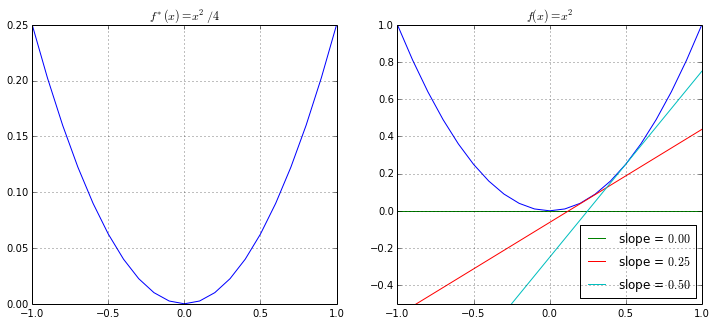

In [2]:
# <!-- collapse=False -->
x = np.arange(-1,1.1,0.1)
y = x**2

lvals = [0,0.25,0.5]
lines = [x*2*l-l**2 for l in lvals]
ystar = x**2/4

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,0)
ax.plot(x,y)
for l in lvals:
    ax.plot(x,x*2*l-l**2,label = "slope = $%.2f$" % (l))
ax.grid(True)
ax.legend(loc=4)
ax.set_ylim(-0.5,1.0)
ax.set_title("$f(x)=x^2$")

ax = fig.add_subplot(1,2,1)
ax.grid(True)
ax.plot(x,ystar)
ax.set_title("$f^*(x)=x^2/4$")

plt.show()


A similar statement is true in higher dimensions, but it's harder to graph so I won't do that. The conjugate function has a number of interesting properties, so we'll go through them now. 

<ol>
<li> $f^*$ is convex. This follows since $\langle u,\theta\rangle - f(u)$ is convex in $\theta$ for all $u$ and the maximum of convex functions is convex.</li>

<li> Suppose $f$ is differentiable. If $f^*(\theta) = \langle u,\theta\rangle - f(u)$, then $\theta=\nabla f(u)$. To see this, just compute $f^*(\theta)$ by differentiating the definition. </li>
<li>
For all $u$,
$$
f^*(\theta)\ge \langle u,\theta\rangle -f(u)
$$
This follows directly from the definition and is called the <i>Fenchel-Young Inequality</i>. 

Suppose $\theta$ is a subgradient of $f$ at $u$. Then
$$
f(w)\ge f(u)+\langle w-u,\theta\rangle\\
\langle u,\theta\rangle - f(u)\ge \langle w,\theta\rangle -f(w)
$$
so that
$$
f^*(\theta)= \langle u,\theta\rangle - f(u)
$$
and the Fenchel-Young inequality is an equality. Similarly, if we assume that $f$ is closed and $f^*(\theta)\ne \infty$ so that there exists $u$ with $f^*(\theta) = \langle u,\theta\rangle - f(u)$, then for all $w$ we have
$$
\langle u,\theta\rangle - f(u)\ge \langle w,\theta\rangle - f(w)\\
f(w)\ge f(u)+\langle w-u,\theta\rangle
$$
so that $\theta$ is a subgradient of $u$.</li>

<li> When $z\in \partial f(w)$ is a subgradient of $f$ at $w$, then $f(w)+f^*(z) = \langle z,w\rangle$. This is just a restatement of the "equality" condition of the Fenchel-Young inequality.

<li> If $f$ is closed and convex, then $f^{**}=f$. </li>
$$
f^{**}(u) =\max_{\theta} \langle \theta,u\rangle - f^*(\theta)= \max_{\theta}\min_{w} \langle \theta,u-w\rangle+f(w)
$$
Now by setting $w=u$, we get $f^{**}(u)\ge f(u)$. Now clearly if $f^*(\theta)=\infty$, then our maximization will not occur at this $\theta$. However, for any $\theta$ with $f^*(\theta)\ne \infty$ we have $f^*(\theta)= \langle w,\theta\rangle - f(w)$ for some $w$ with $\theta$ a subgradient of $f$ at $u$. Thus
$$
f^{**}(u)=\max_{\theta} \langle \theta,u-w\rangle +f (w)\le f(u)
$$
by definition of subgradient and so $f^{**}=f$. </li>
<li>
If $f$ is differentiable, $\nabla f^*(\theta)= w$ where $f^*(\theta) = \langle w,\theta\rangle - f(w)$. To see this, apply fact 2 to $f=f^{**}$ to get
$$
f(w)=f^{**}(w)= \langle w,\theta\rangle -f^*(\theta)
$$
where $\nabla f^*(\theta)=w$. Rearranging, we have
$$
f^*(\theta) = \langle w,\theta\rangle - f(w)
$$
as stated.

Note that we now have an interesting inversion phenomenon going on: $\nabla f(w)=\theta$ when $\nabla f^*(\theta)=w$.
</li>
</ol>

Now we'll define the third main concept: Bregman Divergences.

<div class = "definition">
<h4>Bregman Divergence</h4>
Let $R:S\to \R$ be a differentiable function. Then for any $u,w\in S$ the Bregman divergence $D_R(w\|u)$ is given by
$$
D_R(w\| u) = R(w)- (R(u)+\langle \nabla R(u),w-u\rangle)
$$
</div>

When $R$ is convex as well as differentiable, then $D_R(w\| u)$ is always positive. The Bregman divergence is measuring how much error you acquire at point $w$ by approximating $R$ as a linear function at point $u$. Since approximating things with linear functions is basically the standard tactic in all analysis, this seems like a pretty reasonable thing to have a handle on.

Intuitively, $D_R(w\|u)$ is some kind of spiritual metric. Instead of actually measuring a distance though, the distance is decreased by an amount that reflects how easy it is to approximate $R$ by a linear function. 

For example, suppose $R(x)= x^{2}+x$. Then
$$
D_R(x\|0.5)=x^{2}+x-(0.5^{2}+0.5+(2)(x-0.1)
$$
I've plotted the Bregman divergence of the function $R(x) = x^{1.5}$ below:

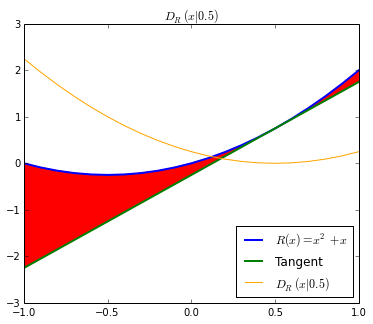

In [3]:
# <!-- collapse=False -->
x = np.arange(-1,1.1,0.1)

R = np.abs(x)**(2)+x
line = 2*x+0.5**2+0.5-2*0.5
D = x**(2)+x-0.5**(2)-0.5-2*(x-0.5)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,0)
ax.plot(x,R,lw = 2,label = "$R(x) = x^2+x$")
ax.plot(x,line,lw = 2,label = "Tangent")
ax.plot(x,D,color='orange',label = "$D_R(x|0.5)$")
ax.fill_between(x,R,line,color = 'red',label="$D_R(x,0.5)$")
ax.set_title("$D_R(x|0.5)$")
ax.legend(loc= 4)
plt.show()

In the above plot, the distance between the blue and green curves is the Bregman divergence, also plotted as the orange line.

The Bregman divergence allows us to succinctly define the concepts of <i>strong smoothness</i> and <i>strong convexity</i>.

<div class = "definition">
<h4>Strong Convexity</h4>
A function $R$ is $\sigma$-strongly convex with respect to a norm $\|\cdot \|$ if
$$
D_R(w\|u) \ge \frac{\sigma}{2}\|w-u\|^2
$$
for all $u$ and $w$.
</div>

Intuitively, strong convexity means that the function is growing <i>faster than a quadratic</i>. So in particular, linear functions are NOT strongly convex, but quadratic functions are.

Alternatively, we have the notion of strong smoothness:

<div class = "definition">
<h4>Strong Smoothness</h4>
A function $R$ is $\sigma$-strongly smooth with respect to a norm $\|\cdot \|$ if
$$
D_R(w\|u)\le \frac{\sigma}{2}\|w-u\|^2
$$
for all $u$ and $w$.
</div>

This is just the opposite - now the function is growing <i>slower</i> than a quadratic. Note that it could still be growing faster than a quadratic. For example, $R(x)=\frac{1}{2}x^2$ is both $1$-strongly convex and $1$-strongly smooth:
$$
D_R(y\|x)=\frac{y^2}{2} - \left(\frac{x^2}{2} + x(y-x)\right)= \frac{1}{2}(y-x)^2
$$

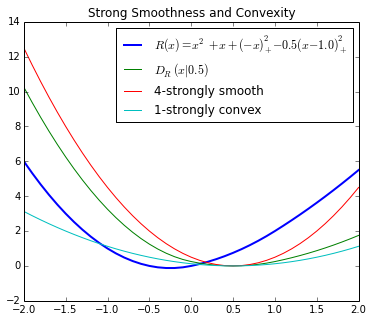

In [4]:
# <!-- collapse=False -->
x = np.arange(-2,2.1,0.1)

R = x**(2)+x + np.maximum(-x,0)**2-0.5*np.maximum(x-1.0,0)**2
line = 2*x+0.5**2+0.5-2*0.5
D = R-0.5**(2)-0.5-2*(x-0.5)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,0)
ax.set_xlim(-2,2.0)
ax.plot(x,R,lw = 2,label = "$R(x) = x^2+x+(-x)_+^2-0.5(x-1.0)_+^2$")
ax.plot(x,D,label = "$D_R(x|0.5)$")
ax.plot(x,2*(x-0.5)**2,label = "4-strongly smooth")
ax.plot(x,0.5*(x-0.5)**2,label = "1-strongly convex")
ax.set_title("Strong Smoothness and Convexity")
ax.legend(loc= 1)
plt.show()

The above function $R(x) = x^2 + x +\max(-x,0)^2-0.5\max(x-1.0,0)^2$ is $4$-strongly smooth and $1$-strongly convex. This is illustrated by the Bregman divergence $D_R(x\|0.5)$, which always less than $\frac{3}{2}(x-0.5)^2$ and greater than $(x-0.5)^2$. Of course, to really check strong convexity/smoothness one needs to check $D_R(x\|y)$ for all $x,y$, not just fixing $y=0.5$.

One important fact about strong convexity and strong smoothness is their effects at minima:

<div class="theorem">
Suppose $R$ is $\sigma$-strongly convex with respect to $\|\cdot\|$, and suppose $x_1=\argmin_x R(x)$. Then

$$
R(x_2)-R(x_1)\ge \frac{\sigma}{2}\|x_1-x_2\|^2
$$

If $R$ is $\sigma$-strongly smooth instead, then

$$
R(x_2)-R(x_1)\le \frac{\sigma}{2}\|x_1-x_2\|^2
$$
</div>

These facts are direct applications of the definitions using the fact that $\nabla R(x_1)=0$ (since $x_1$ minimizes $R$).


Now with all of these notions in hand, we can state a very important fact:

<div class = "theorem">
<h4>Strong/Smooth Duality</h4>
Suppose $R$ is a closed convex function. Then $R$ is $\sigma$-strongly convex with respect to a norm $\|\cdot \|$ if and ony if $R^*$ is $\frac{1}{\sigma}$-strongly smooth respect to the dual norm $\|\cdot \|_*$.
</div>

Let's prove that strong-convexity implies strong smoothness first.

We have
$$
D_{R^*}(w\|\theta) = R^*(w)-R^*(\theta) - \langle \nabla R^*(\theta),(w-\theta)\rangle
$$
Suppose
$$
R^*(w)=\langle x,w\rangle - R(x)\\
R^*(\theta) = \langle y,\theta\rangle - R(y)
$$
Then we also have $\nabla R(x)=w$, $\nabla R^*(\theta) = y$, $\nabla R(y)=\theta$, and $\nabla R^*(w)=x$.
Applying this, we have
$$
\begin{align*}
D_{R^*}(w\|\theta) &= \langle x,w\rangle - R(x) + R(y)-\langle y,\theta\rangle - \langle y,w-\theta\rangle\\
&=R(y)-R(x)-\langle y-x,w\rangle=R(y)-R(x)-\langle y-x,\nabla R(x)\rangle\\
&=D_R(y\|x)
\end{align*}
$$

Thus to show $D_{R^*}(w\|\theta)\le \frac{1}{2\sigma} \|w-\theta\|_*^2$, we can instead show
$$
D_R(y\|x)\le \frac{1}{2\sigma} \|\nabla R(x)-\nabla R(y)\|_*^2
$$

From strong convexity, we have
$$
D_R(x\|y)\ge \frac{\sigma}{2}\|y-x\|^2
$$
$$
R(x)-R(y)-\langle x-y,\nabla R(y)\rangle\ge \frac{\sigma}{2}\|y-x\|^2\\
R(y)-R(x) +\langle x-y,\nabla R(y)\rangle \le -\frac{\sigma}{2}\|y-x\|^2\\
D_R(y\|x) \le -\frac{\sigma}{2}\|y-x\|^2 +\langle x-y,\nabla R(y)-\nabla R(x)\rangle\\
D_R(y\|x) \le -\frac{\sigma}{2}\|y-x\|^2 + \|y-x\| \|\nabla R(y)-\nabla R(x)\|_*
$$
Now set $k=\|y-x\|$. Then we can see that the LHS is maximized for
$$
k= \frac{\|\nabla R(y)-\nabla R(x)\|_*}{\sigma}
$$
which gives
$$
D_R(y\|x) \le \frac{1}{\sigma} \|\nabla R(y)-\nabla R(x)\|_*^2
$$
as desired.

Now for the other direction, suppose that $R^*$ is $\frac{1}{\sigma}$-strongly smooth. Then by the same calculation as before, it suffices to show that
$$
D_{R^*}(w\|\theta) \ge \frac{\sigma}{2}\|\nabla R^*(w)-\nabla R^*(\theta)\|^2
$$
From strong smoothness, we have
$$
-D_{R^*}(\theta\|w) = -R^*(\theta)+R^*(w) + \langle \nabla R^*(w),\theta-w\rangle\ge -\frac{1}{2\sigma}\|w-\theta\|_*^2
$$
Now apply a similar rearrangement:
$$
D_{R^*}(w\|\theta) = R^*(w)-R^*(\theta)-\langle \nabla R^*(\theta),w-\theta\rangle \ge -\frac{1}{2\sigma}\|w-\theta\|_*^2 +\langle w-\theta,\nabla R^*(w)-\nabla R^*(\theta)\rangle\\
= -\frac{1}{2\sigma}\|w-\theta\|_*^2 + \|w-\theta\|\|\nabla R^*(w)-\nabla R^*(\theta)\|_{**}
$$
And now we note that $\|\cdot \|_{**}=\|\cdot \|$ and apply the same optimization trick as before to get
$$
D_{R^*}(w\|\theta) \ge \frac{\sigma}{2}\|\nabla R^*(w)-\nabla R^*(\theta)\|^2
$$
and so we are done.

Strong/Smooth duality is very powerful - when we use a strongly-convex regularizer in an online convex optimization then strong/smooth duality causes some amount of stability (smoothness!) in the prediction vectors.

Moving on, there's one final fact that seems fairly technical, but is a good exercise in these concepts (and is also useful):

<div class="theorem">
Suppose $R(x)$ and $f(x)$ are convex functions, and suppose $R(x)+f(x)$ is 1-strongly convex with respec to $\|\cdot\|$. Let $x_1=\argmin_x R(x)$, and let $x_2=\argmin_x R(x)+f(x)$. If $z$ is an arbitrary subgradient of $f$ at $x_1$, then

$$
\|x_1-x_2\|\le \|z\|_*
$$

and

$$
R(x_1)+f(x_1)-R(x')-f(x')\le\frac{1}{2}\|z\|^2_*
$$

for any $x'$.
</div>

To prove this, first we'll use strong-convexity of $R$:

$$
\frac{1}{2}\|x_1-x_2\|^2\le R(x_1)+f(x_1)-R(x_2)+f(x_2)
$$

Now notice let $R'(x)=R(x)+f(x)-\langle z,x\rangle$. Then since $x_1=\argmin_x R(x)$ and $z$ is a subgradient of $f$ at $x_1$, $0$ is a subgradient of $R'$ at $x_1$ and so $x_1=\argmin_x R'(x)$. Further, since $\langle z,x\rangle$ is a linear function, $R'$ is also 1-strongly convex with respect to $\|\cdot\|$. Therefore

$$
\frac{1}{2}\|x_2-x_1\|^2 \le R(x_2)+f(x_2)-\langle z,x_2\rangle -R(x_1)-f(x_1)+\langle z,x_1\rangle
$$

Adding these two equations and using the definition of the dual norm, we have:

$$
\|x_1-x_2\|^2 \le \langle z,x_1-x_2\rangle \le \|x_1-x_2\|\|z\|_*
$$

from which we can conclude the first statement.

Let's use $R'$ once more to show the second statement. Since $R'$ is strong-convex, $R'^*$ is strongly smooth with respect to $\|\cdot\|_*$. Further,

$$
R'^*(0)=-R'(x_1)=-(R(x_1)+f(x_1)-\langle z,x_1\rangle)\\
x_1=\nabla R'^*(0)
$$

since $x_1=\argmin_x R'$. Also, since $x_2$ is a minimum point of $R(x)+f(x)$, $-z$ is a subgradient of $R'(x)=R(x)+f(x)-\langle z,x\rangle$ at $x_2$. Therefore:

$$
R'^*(-z) = \max_{x} \langle -z,x\rangle  -R(x)-f(x)+\langle z,x\rangle = -\min R(x)+f(x) = -R(x_2)-f(x_2)
$$

Therefore

$$
\frac{1}{2}\|z\|_*^2 \ge D_{R'^*}(-z,0)= R'^*(-z)-R'^*(0)-\langle \nabla R'^*(0),-z\rangle= R(x_1)+f(x_1)-R(x_2)-f(x_2)\ge R(x_1)+f(x_1)-R(x')-f(x')
$$
where the second-to-last equality is simply plugging in our various equations about $R'^*$, and the last is because $x_2=\argmin_x R(x)+f(x)$.